## Forecasting Regime Behaviour with the Hurst Exponent
## Introduction
Understanding the **underlying regime dynamics of financial markets** is a central challenge in quant finance. Markets often alternate between phases of momentum and mean-reversion. Identifying these regimes in advance could enable the design of more adaptive and effective trading strategies.

This project investigates whether the **Hurst exponent**, a statistical measure of long-term memory in time series data, can serve as a useful proxy for regime classification in equity markets. Specifically, we aim to test whether stock return series exhibit:
- **persistent** $ H > 0.5 $, or
- **antipersistent**: $ H < 0.5$

behaviour, and whether this information can be used to condition the application of momentum or mean-reversion strategies.

## Imports and setting up Logging
- The core functions of this notebook will rely on `pandas` and `numpy`
- `dotenv` and `os` correspond to fetching the API key from .env variables
- `requests` is used for the API call
- `time.sleep` is used to download stock data in batches

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from dotenv import load_dotenv
import os
import requests
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from logging import info, warning, critical
from tqdm import tqdm

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger("backtest_logger")
logger.setLevel(logging.INFO)

logger.propagate = False

file_handler = logging.FileHandler("backtest_logs.txt", mode='w')
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

In [3]:
tqdm.pandas()

## Data Collection: Fetching Stock Price Data

### Purpose
To compute the Hurst exponent and investigate whether it is a valid proxy for regime classification in equity markets, we need daily historical closing prices from a defined universe of stocks. This section pulls data for 50-large cap S&P500 stocks (with the omission of $NVDA and $AVGO) from 7th May 2023 to 7th May 2025, using the Polygon API.

### Approach
- Data Source: The Polygon API provides reliable and adjusted stock data. An API key is stored securely in a `.env` file.
- Stock Selection: We use a predifined list of 50 liquid S&P 500 stocks (`SP500_LargeCap_Tickers.csv`), which have remained listed over the historical data window, omitting $NVDA and $AVGO.
- Preprocessing: The data is organised into a multi-index DataFrame with `Date` and `Ticker`, containing `Close`.

High-quality, clean data is critical for an accurate analysis. By focusing on large-cap stocks, we minimise the impact of illiquidity.

In [4]:
stock_tickers_companynames_sector = pd.read_csv("data/SP500_LargeCap_Tickers.csv")
stock_tickers = stock_tickers_companynames_sector["Ticker"].tolist()

In [5]:
stock_tickers.remove("NVDA")
stock_tickers.remove("AVGO")

In [6]:
def fill_aggregate_data(tickers, date_from, date_to, pull_or_pickle="pull"):
    if os.path.exists("data/regime_behaviour_hurst_exponent_data.pkl") and pull_or_pickle != "pull":
        return pd.read_pickle("data/regime_behaviour_hurst_exponent_data.pkl")

    else:
        load_dotenv()
        api_key = os.getenv("POLYGON_API_KEY")

        all_stock_data = []

        for number, ticker in enumerate(tickers):
            url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{date_from}/{date_to}"
            params = {
                "adjusted":"true",
                "sort":"asc",
                "limit":50000,
                "apiKey":api_key
            }

            response = requests.get(url,params=params)
            response_data = response.json()["results"]

            if response.status_code != 200:
                warning(f"Error fetching {ticker}: {response.status_code}")
                continue
            try:
                response_data = response.json().get("results", [])
                if not response_data:
                    info(f"No data for {ticker}")
                    continue

                info(f"Successfully pulled data for {ticker} ({str(number+1)}/{str(len(tickers))})")
            except ValueError:
                warning(f"Invalid JSON for {ticker}")
                continue

            response_df = pd.DataFrame(response_data)[["c", "t"]]
            response_df["Ticker"] = ticker
            response_df["t"] = pd.to_datetime(response_df["t"], unit="ms")
            response_df = response_df.rename(columns={"c": "Close", "t": "Date"}).set_index(["Date", "Ticker"])
            all_stock_data.append(response_df)
            sleep(13)  # to avoid being rate-limited

        if not all_stock_data:
            critical("No data retrieved for any tickers")

        aggregate_ticker_price_volume_data = pd.concat(all_stock_data)
        aggregate_ticker_price_volume_data.index.name = "Date"
        aggregate_ticker_price_volume_data = aggregate_ticker_price_volume_data.reset_index().set_index(["Date","Ticker"]).sort_index()

        aggregate_ticker_price_volume_data.to_pickle("data/regime_behaviour_hurst_exponent_data.pkl")

        return aggregate_ticker_price_volume_data

In [7]:
aggregate_ticker_price_data = fill_aggregate_data(stock_tickers, "2023-05-07","2025-05-07",pull_or_pickle="pickle")
aggregate_ticker_price_data.index = pd.MultiIndex.from_tuples(
    [(pd.to_datetime(i[0]),i[1]) for i in aggregate_ticker_price_data.index],
    names=aggregate_ticker_price_data.index.names
)

## Computing the Hurst Exponent
- For each stock, we will compute a rolling Hurst exponent using a 126-day window.
- We will use **Detrended Fluctuation Analysis** (DFA) on the log of closing prices for each stock.
    - DFA is a method used to estimate the **Hurst Exponent** $ H $ of a series.
    - It is more robust than the classical R/S method, especially for non-stationary signals.
    - We will use the log price sa it ensures scale invariance.

### Implementation
- To apply the rolling 126-day window for computing the Hurst exponent, we create a wrapper function called `safe_dfa` which takes in a list `x`, over window `window_size`, and computes the Hurst.
- Then, we create a new series called `hurst_series`, where we group the log close prices by ticker, and then progressively apply the `safe_dfa` function.
- Then, we flatten the series, and insert it into our log price dataframe.

In [8]:
ticker_log_and_price_data = aggregate_ticker_price_data.copy()
ticker_log_and_price_data["Log_Close"] = np.log(aggregate_ticker_price_data["Close"].dropna())

In [9]:
window_size = 126

In [10]:
def manual_dfa(x, min_scale=10, max_scale_factor=0.25):
    if np.isnan(x).any() or len(x) < min_scale * 4 or np.std(x) < 1e-5:
        return np.nan
    try:
        n = len(x)
        max_scale = int(n * max_scale_factor)
        scales = np.logspace(np.log10(min_scale), np.log10(max_scale), num=10, dtype=int)
        fluctuations = []
        for scale in scales:
            segments = n // scale
            if segments < 2:
                continue
            rms = []
            for i in range(segments):
                idx = slice(i * scale, (i + 1) * scale)
                segment = x[idx]
                trend = np.polyfit(np.arange(scale), segment, 1)
                detrended = segment - np.polyval(trend, np.arange(scale))
                rms.append(np.sqrt(np.mean(detrended ** 2)))
            if np.mean(rms) <= 0:  # Avoid log(0) or negative
                return np.nan
            fluctuations.append(np.mean(rms))
        if len(fluctuations) < 2:
            return np.nan

        log_scales = np.log10(scales[:len(fluctuations)])
        log_fluctuations = np.log10(fluctuations)
        slope, _, _, _, _ = linregress(log_scales, log_fluctuations)
        return slope
    except Exception as e:
        print(f"Manual DFA failed: {e}")
        return np.nan

In [11]:
if os.path.exists("data/regime_exponent.pkl"):
    hurst_series = pd.read_pickle("data/regime_exponent.pkl")
else:
    hurst_series = (
        ticker_log_and_price_data.groupby("Ticker").progress_apply(
            lambda g: g["Log_Close"].rolling(window=window_size).apply(
                lambda x: manual_dfa(x, min_scale=10), raw=False
            )
        )
    )
    hurst_series.to_pickle("data/regime_exponent.pkl")

ticker_log_and_price_data["Hurst_Exp"] = hurst_series.reset_index(level=0, drop=True)
ticker_log_and_price_data = ticker_log_and_price_data.dropna()
print(ticker_log_and_price_data["Hurst_Exp"].describe())

count    18048.000000
mean         0.560275
std          0.108533
min          0.183700
25%          0.488638
50%          0.561258
75%          0.633892
max          0.973382
Name: Hurst_Exp, dtype: float64


In [12]:
ticker_log_and_price_data.isna().sum()

Close        0
Log_Close    0
Hurst_Exp    0
dtype: int64

In [13]:
ticker_log_and_price_data.describe()

,Close,Log_Close,Hurst_Exp
count,18048.000000,18048.000000,18048.000000
mean,242.876907,5.216556,0.560275
std,182.129865,0.784455,0.108533
min,18.130000,2.897568,0.183700
25%,124.150000,4.821490,0.488638
50%,179.685000,5.191205,0.561258
75%,329.477500,5.797508,0.633892
max,1156.490000,7.053145,0.973382


## Signal Generation
- We will define a simple regime classifier:
    - $H > 0.55 \rightarrow $ Persisent, use **momentum strategy**
    - $H < 0.45 \rightarrow $ Antipersistent, use **mean-reversion strategy**
    - Otherwise, neutral

In [14]:
def classify_regime(row):
    if row["Hurst_Exp"] > 0.55:
        return "persistent"
    elif row["Hurst_Exp"] < 0.45:
        return "antipersistent"
    else:
        return "neutral"

In [15]:
ticker_log_and_price_data["regime"] = ticker_log_and_price_data.apply(classify_regime, 1)

In [16]:
ticker_log_and_price_data.head(20)

Close  Log_Close  Hurst_Exp          regime
Date                Ticker                                                
2023-11-06 05:00:00 AAPL    179.2300   5.188670   0.728775      persistent
                    ABBV    141.2000   4.950177   0.558099      persistent
                    ADBE    565.4500   6.337622   0.563212      persistent
                    AMD     111.7500   4.716264   0.567626      persistent
                    AMZN    139.7400   4.939784   0.476448         neutral
                    BA      192.9500   5.262431   0.442668  antipersistent
                    BAC      28.3300   3.343921   0.486193         neutral
                    BRK.B   346.6300   5.848258   0.616794      persistent
                    CAT     238.2800   5.473446   0.570889      persistent
                    COST    569.8200   6.345321   0.576968      persistent
                    CRM     207.4200   5.334746   0.642464      persistent
                    CSCO     53.2900   3.975749   0.466312         neutral
                    CVX     147.0000   4.990433   0.352111  antipersistent
                    DE      378.2500   5.935555   0.816897      persistent
                    DIS      84.0200   4.431055   0.538856         neutral
                    FDX     245.3300   5.502604   0.411922  antipersistent
                    GE       89.2099   4.490992   0.232646  antipersistent
                    GOOG    131.4500   4.878627   0.565266      persistent
                    GOOGL   130.2500   4.869456   0.563554      persistent
                    GS      323.9100   5.780466   0.605055      persistent

## Backtesting the Regime-Conditioned Strategy
On the last day of each month, we will:
- Group stocks by their regime
- If Hurst suggests momentum -> rank stocks by their 21-day return -> long top decile, short bottom decile
- If Hurst suggests mean-reversion -> long bottom decile, short top decile
- Both legs are equally weighted, and the portfolio is rebalanced monthly

In [17]:
type(ticker_log_and_price_data.index.get_level_values("Date"))

pandas.core.indexes.datetimes.DatetimeIndex

In [22]:
def backtest(df, verbose):
    df = df.copy()

    starting_capital = 1000000
    portfolio_returns = {"momentum": [], "mean_reversion": []}
    previous_portfolio_value = starting_capital
    active_positions = {}
    cash = starting_capital
    trading_cost = 0.01

    df_reset = df.reset_index()
    df_reset["Year_Month"] = df_reset["Date"].dt.to_period("M")
    month_end_dates = df_reset.groupby("Year_Month").last()["Date"]

    for index, month_end in month_end_dates.items():
        estimate = month_end - pd.offsets.BDay(21)
        first_trading_day = df.loc[df.index.get_level_values("Date") >= estimate].index.get_level_values("Date").min()

        # Close existing positions and update cash
        momentum_returns = []
        mean_r_returns = []
        for ticker in list(active_positions.keys()):
            try:
                entry_price = active_positions[ticker]["price"]
                shares = active_positions[ticker]["shares"]
                strategy = active_positions[ticker]["strategy"]
                exit_price = df.loc[(first_trading_day, ticker), "Close"]

                # Calculate return
                if shares > 0:  # Long position
                    ret = (exit_price - entry_price) / entry_price
                    if verbose:
                        print(f"[EXIT] Closed {ticker} @ {exit_price}, num shares: {shares} for PnL: {shares*(exit_price-entry_price)}")
                else:  # Short position
                    ret = -(exit_price - entry_price) / entry_price
                    if verbose:
                        print(f"[EXIT] Closed {ticker} @ {exit_price}, num shares: {shares} for PnL: {shares*(exit_price-entry_price)}")

                # Append to appropriate strategy returns
                if strategy == "momentum":
                    momentum_returns.append(ret)
                elif strategy == "mean_reversion":
                    mean_r_returns.append(ret)

                # Update cash (existing logic)
                if shares > 0:
                    cash += shares * exit_price
                else:
                    cash -= abs(shares) * exit_price

                del active_positions[ticker]
            except KeyError:
                print(f"No price data for {ticker} on {first_trading_day}")
                continue

        # Append average returns for each strategy
        portfolio_returns["momentum"].append(sum(momentum_returns) / len(momentum_returns) if momentum_returns else 0)
        portfolio_returns["mean_reversion"].append(sum(mean_r_returns) / len(mean_r_returns) if mean_r_returns else 0)

        # Dynamically update capital allocation based on current cash
        max_capital_allocation = cash * 0.9
        max_capital_by_strategy = max_capital_allocation / 2

        subset = df.loc[df.index.get_level_values('Date') == month_end]

        momentum_regime = subset[subset['regime'] == "persistent"]
        mean_reverting_regime = subset[subset['regime'] == "antipersistent"]

        if momentum_regime.empty:
            print(f"No persistent regime stocks for {month_end}")
        if mean_reverting_regime.empty:
            print(f"No antipersistent regime stocks for {month_end}")

        # Momentum regime signal generation
        current_momentum_stock_prices = momentum_regime.groupby(level="Ticker")["Close"].first()
        past_momentum_stock_prices = df.loc[
            (df.index.get_level_values("Date") == first_trading_day) & 
            (df.index.get_level_values("Ticker").isin(momentum_regime.index.get_level_values("Ticker"))),
            "Close"
        ]
        past_momentum_stock_prices = past_momentum_stock_prices.reset_index().set_index("Ticker")["Close"]

        combined_momentum = pd.concat([current_momentum_stock_prices, past_momentum_stock_prices], axis=1, keys=["Current", "Past"])
        combined_momentum["Return"] = (combined_momentum["Current"] / combined_momentum["Past"]) - 1
        combined_momentum = combined_momentum.dropna(subset=["Return"])

        if not combined_momentum.empty:
            combined_momentum["Rank"] = combined_momentum["Return"].rank(method='first', ascending=False)
            n_stocks = combined_momentum.shape[0]
            top_bottom_n = max(1, int(n_stocks * 0.1))
            combined_momentum["Signal"] = 0
            combined_momentum.loc[combined_momentum["Rank"] <= top_bottom_n, "Signal"] = 1
            combined_momentum.loc[combined_momentum["Rank"] > (n_stocks - top_bottom_n), "Signal"] = -1

        # Mean-reverting regime signal generation
        current_mean_r_stock_prices = mean_reverting_regime.groupby(level="Ticker")["Close"].first()
        past_mean_r_stock_prices = df.loc[
            (df.index.get_level_values("Date") == first_trading_day) &
            (df.index.get_level_values("Ticker").isin(mean_reverting_regime.index.get_level_values("Ticker"))),
            "Close"
        ]

        past_mean_r_stock_prices = past_mean_r_stock_prices.reset_index().set_index("Ticker")["Close"]

        combined_mean_r = pd.concat([current_mean_r_stock_prices, past_mean_r_stock_prices], axis=1, keys=["Current", "Past"])
        combined_mean_r["Return"] = (combined_mean_r["Current"] / combined_mean_r["Past"]) - 1
        combined_mean_r = combined_mean_r.dropna(subset=["Return"])

        if not combined_mean_r.empty:
            combined_mean_r["Rank"] = combined_mean_r["Return"].rank(method='first', ascending=False)
            n_stocks = combined_mean_r.shape[0]
            top_bottom_n = max(1, int(n_stocks * 0.1))
            combined_mean_r["Signal"] = 0
            combined_mean_r.loc[combined_mean_r["Rank"] <= top_bottom_n, "Signal"] = -1
            combined_mean_r.loc[combined_mean_r["Rank"] > (n_stocks - top_bottom_n), "Signal"] = 1

        # Position allocation for momentum
        if not combined_momentum.empty:
            signals = combined_momentum[combined_momentum["Signal"] != 0]
            position_capital = max_capital_by_strategy / len(signals) if len(signals) > 0 else 0
            for row in combined_momentum.iterrows():
                if len(signals) == 0:
                    continue

                ticker = row[0]
                stock_price = row[1]["Current"]
                signal = row[1]["Signal"]

                if signal == 1:
                    num_shares = position_capital / stock_price
                    cash -= num_shares * stock_price + (num_shares * stock_price * trading_cost)
                    active_positions[ticker] = {
                        "price": stock_price,
                        "shares": num_shares,
                        "strategy": "momentum"
                    }
                    if verbose:
                        print(f"[MOMENTUM] Long {ticker} @ {stock_price}, shares: {num_shares}!")

                elif signal == -1:
                    num_shares = position_capital / stock_price
                    cash += num_shares * stock_price - (num_shares * stock_price * trading_cost)
                    active_positions[ticker] = {
                        "price": stock_price,
                        "shares": -num_shares,
                        "strategy": "momentum"
                    }
                    if verbose:
                        print(f"[MOMENTUM] Short {ticker} @ {stock_price}, shares: {num_shares}!")

        # Position allocation for mean-reverting
        if not combined_mean_r.empty:
            signals = combined_mean_r[combined_mean_r["Signal"] != 0]
            position_capital = max_capital_by_strategy / len(signals) if len(signals) > 0 else 0
            for row in combined_mean_r.iterrows():
                if len(signals) == 0:
                    continue

                ticker = row[0]
                stock_price = row[1]["Current"]
                signal = row[1]["Signal"]

                if signal == 1:
                    num_shares = position_capital / stock_price
                    cash -= num_shares * stock_price + (num_shares * stock_price * trading_cost)
                    active_positions[ticker] = {
                        "price": stock_price,
                        "shares": num_shares,
                        "strategy": "mean_reversion"
                    }
                    if verbose:
                        print(f"[MEAN REVERSION] Long {ticker} @ {stock_price}, shares: {num_shares}!")

                elif signal == -1:
                    num_shares = position_capital / stock_price
                    cash += num_shares * stock_price - (num_shares * stock_price * trading_cost)
                    active_positions[ticker] = {
                        "price": stock_price,
                        "shares": -num_shares,
                        "strategy": "mean_reversion"
                    }
                    if verbose:
                        print(f"[MEAN REVERSION] Short {ticker} @ {stock_price}, shares: {num_shares}!")

    # Close remaining active positions at the end of the trading period
    if active_positions:
        final_date = df.index.get_level_values("Date").max()
        momentum_returns = []
        mean_r_returns = []
        for ticker in list(active_positions.keys()):
            try:
                entry_price = active_positions[ticker]["price"]
                shares = active_positions[ticker]["shares"]
                strategy = active_positions[ticker]["strategy"]
                exit_price = df.loc[(final_date, ticker), "Close"]

                # Calculate return
                if shares > 0:  # Long position
                    ret = (exit_price - entry_price) / entry_price
                    if verbose:
                        print(f"[FINAL EXIT] Closed {ticker} @ {exit_price}, num shares: {shares} for PnL: {shares*(exit_price-entry_price)}")
                else:  # Short position
                    ret = -(exit_price - entry_price) / entry_price
                    if verbose:
                        print(f"[FINAL EXIT] Closed {ticker} @ {exit_price}, num shares: {shares} for PnL: {shares*(exit_price-entry_price)}")

                # Append to appropriate strategy returns
                if strategy == "momentum":
                    momentum_returns.append(ret)
                elif strategy == "mean_reversion":
                    mean_r_returns.append(ret)

                # Update cash
                if shares > 0:
                    cash += shares * exit_price
                else:
                    cash -= abs(shares) * exit_price

                del active_positions[ticker]
            except KeyError:
                print(f"No price data for {ticker} on {final_date}")
                continue

        # Append average returns for each strategy
        portfolio_returns["momentum"].append(sum(momentum_returns) / len(momentum_returns) if momentum_returns else 0)
        portfolio_returns["mean_reversion"].append(sum(mean_r_returns) / len(mean_r_returns) if mean_r_returns else 0)

    return portfolio_returns

In [23]:
backtest_results = backtest(ticker_log_and_price_data, verbose=False)

In [24]:
backtest_results

{'momentum': [0,
  np.float64(0.0),
  np.float64(-0.005575184580459106),
  np.float64(0.0),
  np.float64(-0.015619783783499512),
  np.float64(0.01377707449333992),
  np.float64(-0.009577160281159049),
  np.float64(0.010389924892942631),
  np.float64(0.011458084458184623),
  np.float64(-0.00015681912734467982),
  np.float64(0.0),
  np.float64(-0.009288832109373708),
  np.float64(0.00325993536647058),
  np.float64(0.013286437310534931),
  np.float64(0.0032105500379590183),
  np.float64(0.0034565323018412595),
  np.float64(0.0),
  np.float64(-0.004789373844148489),
  np.float64(-0.28757974857952057),
  np.float64(0.0)],
 'mean_reversion': [0,
  np.float64(0.0),
  np.float64(0.018446018960578528),
  np.float64(0.0),
  np.float64(0.008004743034909471),
  np.float64(-0.00706817180642334),
  np.float64(0.015897747396140156),
  np.float64(-0.028425985139926526),
  np.float64(-0.00650856740639931),
  np.float64(-0.04863705941120977),
  np.float64(0.0),
  np.float64(0.001167600001123613),
  np.f

## Plotting the results of the backtest

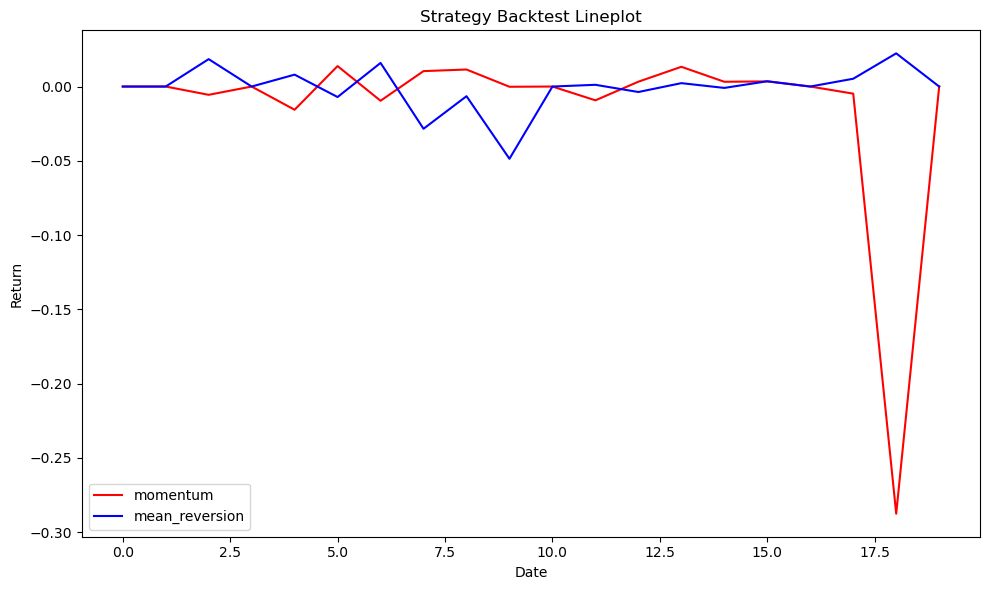

In [25]:
plt.figure(figsize=(10,6))
colours = ["red","blue"]

for i, strategy in enumerate(backtest_results.keys()):
    sns.lineplot(backtest_results[strategy], color=colours[i], label=strategy)

plt.title("Strategy Backtest Lineplot")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()